# Week 3

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
from pandas_datareader import data 
from datetime import datetime
from scipy.optimize import minimize

In [69]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
import sys
sys.path.append("../")
import edhec_risk_kit as erk

In [71]:
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark")

## The limits of Portfolio diversification
Things that diversification **is effective** at: 

1. diversification is an effective way to increase the reward per unit of risk;
2. diversification is an effective way to decrease **idiosyncratic or specific** risk: in fact, it allows investors to reduce specific risk within their portfolios, which is how they can achieve a high reward per unit of risk.

Things that diversification **is not effective** at: 

1. diversification **is not** an effective way to decrease the **systemic risk**: basically, if the entire market collapses, it does not really matter how much your portfolio is diversified since correlation levels tend to increase and diversification benefits tend to disappear.
 
In the following, we want to highlight the last point, i.e., we want to show that in case of huge financial crisis the diversification of a portfolio is not a guarantee of less risk.

Let us load the follwing dataset about 30 Industry portfolios:

In [72]:
nind = 30

In [73]:
ind_rets   = erk.get_ind_file(filetype="rets", nind=nind)
ind_nfirms = erk.get_ind_file(filetype="nfirms", nind=nind)
ind_size   = erk.get_ind_file(filetype="size", nind=nind)

In [74]:
ind_rets.head(3)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386


The dataframe **ind_rets** contains the returns (from 1926-2018) of $30$ portfolios including different industry sectors such as food, beer, smoke, etc. 

Such portofolios are constructed by using the weights equal to the corresponding market capitalizations. 
The **market capitalization** of a company is the **total value of the company** defined as 
the number of shares outstanding of that company multiplied by the share price 
(for example, there are 100,000 shares of company "A", and the share price is 20.3, hence the market cap of company "A" is 2,030,000).


For example, the columns **Food** contains the returns of a portfolio consisting of all the companies in the food sectors for each month from 1926 to 2019. The portfolio has been constructed by weighting each company according to its market capitalization.

Now, **the number of firms** composing each single sector are stored in **ind_nfirms**:

In [75]:
ind_nfirms.head(3)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,43.0,3.0,16.0,7.0,2.0,8.0,12.0,7.0,17.0,13.0,...,5.0,3.0,7.0,6.0,74.0,2.0,33.0,6.0,12.0,4.0
1926-08,43.0,3.0,16.0,7.0,2.0,8.0,12.0,7.0,17.0,13.0,...,5.0,3.0,7.0,6.0,74.0,2.0,33.0,6.0,12.0,4.0
1926-09,43.0,3.0,16.0,7.0,2.0,8.0,12.0,7.0,17.0,13.0,...,5.0,3.0,7.0,6.0,74.0,2.0,33.0,6.0,12.0,4.0


that is, in 1926-07, there were 43 (food) companies in the Food portfolio, 3 (beer) companies in the Beer portfolio, etc.

Finally, the datframe **ind_size** contains the **average size** of the companies composing the portfolio:

In [76]:
ind_size.head(3)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,35.98,7.12,59.72,26.41,12.02,22.27,18.36,25.52,57.59,6.18,...,350.36,13.60,56.70,35.35,66.91,1.19,46.65,10.82,18.83,24.25
1926-08,36.10,6.75,60.47,27.17,13.33,22.13,19.83,25.80,62.13,6.20,...,353.27,14.75,57.74,37.86,67.99,0.90,46.57,11.00,18.88,25.51
1926-09,37.00,8.58,64.03,27.30,14.67,21.18,19.29,26.73,65.53,6.71,...,360.96,15.05,59.61,36.82,71.02,0.95,46.11,10.94,19.67,27.21


that is, the average size of the 43 Food companies in 1926-07 was 35.98, the average size of the 3 Beer companies was 7.12, ans so on (it does not matter the unit). 
By **average size** we mean the **average of the market capitalizations** of the 43 food companies, of the 3 Beer companies, etc.

### Constructing the index

The first thing to do is to get the **market capitalization of each industry sector.**
This is simply given by the number of firms times their average size:

In [77]:
ind_mkt_cap = ind_nfirms * ind_size
ind_mkt_cap.head(3)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,1547.14,21.36,955.52,184.87,24.04,178.16,220.32,178.64,979.03,80.34,...,1751.80,40.80,396.90,212.10,4951.34,2.38,1539.45,64.92,225.96,97.00
1926-08,1552.30,20.25,967.52,190.19,26.66,177.04,237.96,180.60,1056.21,80.60,...,1766.35,44.25,404.18,227.16,5031.26,1.80,1536.81,66.00,226.56,102.04
1926-09,1591.00,25.74,1024.48,191.10,29.34,169.44,231.48,187.11,1114.01,87.23,...,1804.80,45.15,417.27,220.92,5255.48,1.90,1521.63,65.64,236.04,108.84


Now, we want to get the **total market capitalization**, in order to get the fraction of the 
total market capitalization which is in each industry. The total market capitalization
is a single time series **representing the total value of the market at each month**. 
This can be obtained by summing each market capitalization of each sector every month, i.e., 
by horizontally summing the **ind_mkt_cap**:

In [78]:
# total market capitalization: 
total_mkt_cap = ind_mkt_cap.sum(axis=1)
total_mkt_cap.head()

1926-07    26657.94
1926-08    27436.34
1926-09    28060.41
1926-10    28057.23
1926-11    27198.40
Freq: M, dtype: float64

and now, we can divide each single market cap by the total market cap:

In [79]:
ind_cap_weights = ind_mkt_cap.divide(total_mkt_cap, axis=0)
ind_cap_weights.head(3)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.058037,0.000801,0.035844,0.006935,0.000902,0.006683,0.008265,0.006701,0.036726,0.003014,...,0.065714,0.001531,0.014889,0.007956,0.185736,0.000089,0.057748,0.002435,0.008476,0.003639
1926-08,0.056578,0.000738,0.035264,0.006932,0.000972,0.006453,0.008673,0.006583,0.038497,0.002938,...,0.064380,0.001613,0.014732,0.008280,0.183379,0.000066,0.056014,0.002406,0.008258,0.003719
1926-09,0.056699,0.000917,0.036510,0.006810,0.001046,0.006038,0.008249,0.006668,0.039700,0.003109,...,0.064318,0.001609,0.014870,0.007873,0.187292,0.000068,0.054227,0.002339,0.008412,0.003879


This means that, for example, in 1926-07 the total market capitalization was $26657.94$ and that 
the Food companies (in the portfolio for this month) represented all together about the $5.8\%$, 
the Beer companies (in the portfolio for this month) represented all together about the $0.08\%$, and so on. 

Let us visualize these things:

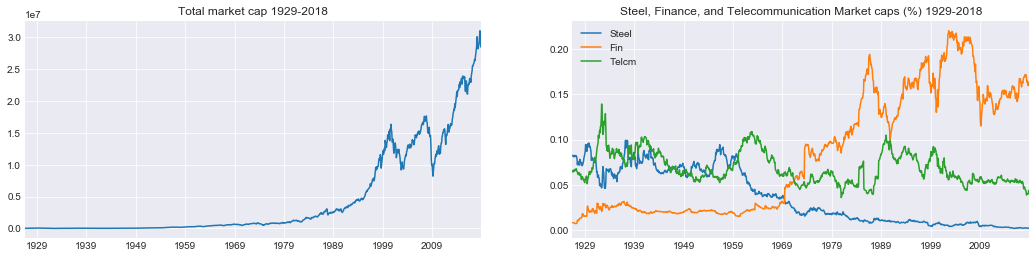

In [80]:
fig, ax = plt.subplots(1,2,figsize=(18,4)) 
total_mkt_cap.plot(grid=True, ax=ax[0]) 
ax[0].set_title("Total market cap 1929-2018")

ind_cap_weights[["Steel","Fin","Telcm"]].plot(grid=True, ax=ax[1])
ax[1].set_title("Steel, Finance, and Telecommunication Market caps (%) 1929-2018")
plt.show()

In the plot on the left we have the total market cap from 1929 to 2018. On the right, we have the Steel, Finance, and Telecommunication Market 
caps 1929-2018 as a percentage of the total market cap. 

For example, notice that while the Finance sector was around the $3\%$ of the total market cap in 1929, in 2018 it was more than $15\%$. 
On the other hand, the Steel sector was around the $9\%$ in 1929 until decreasing to the $0.2\%$ in 2018.

Now, let us find the **total maket return**, i.e., the return time series from the total market. 
This is simply going to be the sum of the weights of each sector times their corresponding monthly returns.

Once we have the total market return series, we can **compound** it and obtain 
the **total market index** (what we called the **wealth** in week 1):

In [81]:
total_market_return = (ind_cap_weights * ind_rets).sum(axis=1)

# suppose to have invested a capital of 1000$ in the market
capital = 1000
total_market_index = capital * (1 + total_market_return).cumprod()

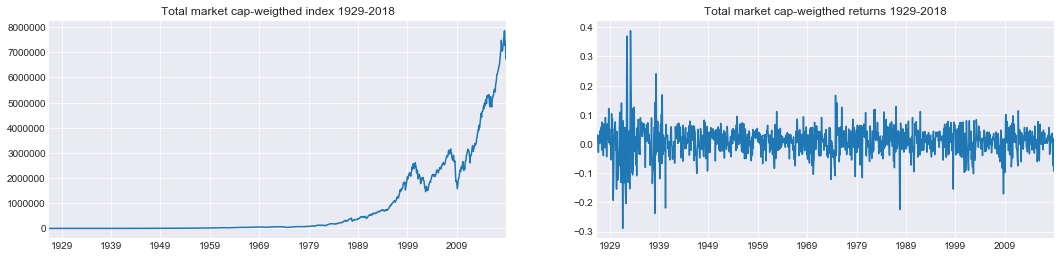

In [82]:
fig, ax = plt.subplots(1,2,figsize=(18,4)) 

total_market_index.plot(grid=True, ax=ax[0]) 
ax[0].set_title("Total market cap-weigthed index 1929-2018")

total_market_return.plot(grid=True, ax=ax[1])
ax[1].set_title("Total market cap-weigthed returns 1929-2018")

plt.show()

Notice that the plot of the (cap-weigthed) index is, of course, the same (but different in values) as the plot of the total market capitalization.

Next, we what to see **how returns are related to market correlations**.

### Rolling returns

Let us plot the total market index, say from 1990, and plot together some moving average (MA) series corresponding to 60, 36, and 12 months (i.e, 5, 3, and 1 years), respectively, just to look at how the **.rolling** method works.

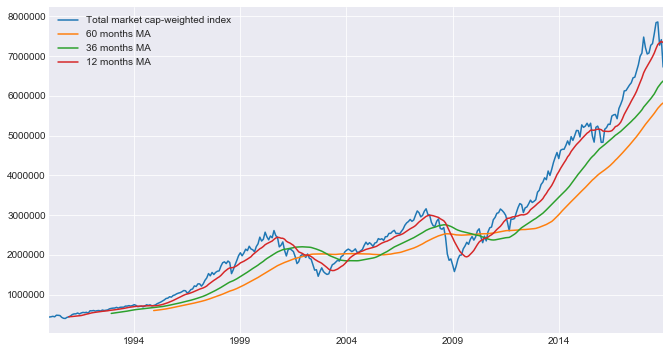

In [83]:
total_market_index["1990":].plot(grid=True, figsize=(11,6), label="Total market cap-weighted index")

total_market_index["1990":].rolling(window=60).mean().plot(grid=True, figsize=(11,6), label="60 months MA") # 5 years MA
total_market_index["1990":].rolling(window=36).mean().plot(grid=True, figsize=(11,6), label="36 months MA") # 3 years MA
total_market_index["1990":].rolling(window=12).mean().plot(grid=True, figsize=(11,6), label="12 months MA") # 1 year MA

plt.legend()
plt.show()

Ok. Now compute the **trailing 36 months compound returns of total_market_return**. 
That is, we take the total market return series and open the rolling windows for 36 months. Then, for each rolling window (by using **.aggregate**) we compound the returns: 

In [84]:
tmi_trail_36_rets = total_market_return.rolling(window=36).aggregate( erk.annualize_rets, periods_per_year=12 )

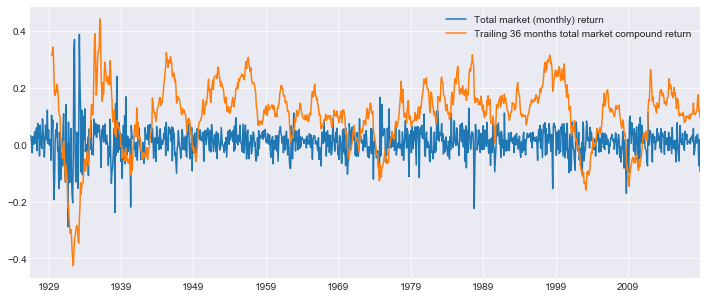

In [85]:
# Plot them
total_market_return.plot(grid=True, figsize=(12,5), label="Total market (monthly) return")
tmi_trail_36_rets.plot(grid=True, figsize=(12,5), label="Trailing 36 months total market compound return")
plt.legend()
plt.show()

### Rolling correlations: multi-indices and groupby

Let us now compute the **rolling** correlations across industries, in the same way as we have computed the trailing 36 months compound returns. We use the **.corr()** method which computes the **pairwise correlation** between columns of the dataframe.

In [86]:
rets_trail_36_corr = ind_rets.rolling(window=36).corr()
rets_trail_36_corr.index.names = ["date","industry"]
rets_trail_36_corr.tail()

Food      Beer     Smoke     Games     Books     Hshld  \
date    industry                                                               
2018-12 Whlsl     0.474948  0.356983  0.122672  0.510425  0.803362  0.419280   
        Rtail     0.517856  0.406107  0.030283  0.676464  0.636320  0.358336   
        Meals     0.370187  0.385483  0.122007  0.301516  0.520649  0.308216   
        Fin       0.298823  0.192706  0.027593  0.480276  0.694812  0.162690   
        Other     0.436952  0.376565  0.224010  0.331829  0.558072  0.390610   

                     Clths      Hlth     Chems     Txtls  ...     Telcm  \
date    industry                                          ...             
2018-12 Whlsl     0.570071  0.739764  0.785796  0.634197  ...  0.648092   
        Rtail     0.676598  0.714933  0.626034  0.634202  ...  0.562238   
        Meals     0.302176  0.416193  0.520023  0.491726  ...  0.406184   
        Fin       0.425899  0.658468  0.760151  0.577090  ...  0.420863   
        Other     0.467099  0.645035  0.712511  0.520953  ...  0.607868   

                     Servs     BusEq     Paper     Trans     Whlsl     Rtail  \
date    industry                                                               
2018-12 Whlsl     0.567395  0.543362  0.764252  0.829185  1.000000  0.744842   
        Rtail     0.762616  0.628246  0.656510  0.630615  0.744842  1.000000   
        Meals     0.444629  0.399438  0.627113  0.663358  0.643879  0.616947   
        Fin       0.585418  0.517947  0.670936  0.760730  0.746480  0.611883   
        Other     0.460322  0.434487  0.773798  0.756961  0.767652  0.619918   

                     Meals       Fin     Other  
date    industry                                
2018-12 Whlsl     0.643879  0.746480  0.767652  
        Rtail     0.616947  0.611883  0.619918  
        Meals     1.000000  0.502563  0.605226  
        Fin       0.502563  1.000000  0.734837  
        Other     0.605226  0.734837  1.000000  

[5 rows x 30 columns]

The dataframe above is a **time series of correlation matrices**. 
That is, each matrix represents the trailing $36$ months **correlation matrix** of compounded 
returns of the industries for each available data. 
That is, if we look at **rets_trail_36_corr.tail(30)** we would see the (trailing 36 months) correlation matrix of industries during the last available month, i.e., 2018-12,. 
If we look at **rets_trail_36_corr.tail(60)** we would see the same correlation matrix for 2018-12 and the (trailing 36 months) correlation matrix of 2018-11, etc.

In the example above, we see that during 2018-12, the  (trailing 36 months) correlation between Whlsl and Food was about 0.47, 
the (trailing 36 months) correlation betwenn Rtail and Smoke was about 0.03, and so on. 

Notice that due to the structure of such a dataframe, we have a **double index**: per each index date, we have the set of index industries. 

Next, we want to the see **averages of all these correlation matrices** for each date. To do that, we first get single correlation matrices  using **groupby by date** and the we take the average of them. The result is a pd.Series:

In [87]:
ind_trail_36_corr = rets_trail_36_corr.groupby(level="date").apply(lambda corrmat: corrmat.values.mean())

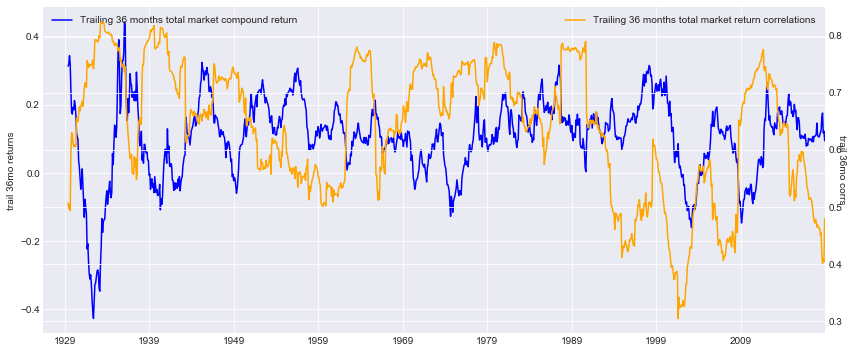

In [88]:
fig, ax1 = plt.subplots(1,1,figsize=(14,6))

tmi_trail_36_rets.plot(ax=ax1, color="blue", grid=True, label="Trailing 36 months total market compound return")
ax2 = ax1.twinx()
ind_trail_36_corr.plot(ax=ax2, color="orange", grid=True, label="Trailing 36 months total market return correlations")

ax1.set_ylabel('trail 36mo returns')
ax2.set_ylabel('trail 36mo corrs',rotation=-90)
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.show()

For example, during the 1929 crisis, we see that when (trailing 36 months) returns of the overall market falls, the average correlation of industries of the market increases, and that when returns recover, then correlations fall. 
This can be also seen in the Lehman Brother crisis. When in 2007 returns started to fall then correlations increased.

When this happens, we simply realize **the limits of diversification**. Returns from the entire market falls means that, on average, all industries in the market are suffering losses, i.e., their correlation increases, and it does not really matter how diversified the portfolio is. **Diversification may not help you when market crashes**.

However, **this is not always so: look at the dot com crisis of from 1999.** Returns and correlations follow the same trend, showing that in this case diversification could help to stop losses$\dots$

In general:

In [89]:
tmi_trail_36_rets.corr(ind_trail_36_corr)

-0.2801006506288413

this is, the correlation between the series of (trailing 36 months) compounded returns and the series of average correlations 
across industries **is negative**.

## Risk insurance strategies 

Recent market crises have highlighted the benefits of risk-controlled strategies that allow investors to benefit from **downside risk protection**. 
Here, we describe a risk insurance strategy and then we move on to more sophisticated strategies that aim at achieving 
the highest possible upside potential while imposing stringent limits to portfolio drawdown.

### Constant Proportion Portfolio Insurance (CPPI)

The **CPPI** procedure allows to obtain option-like (convex) payoffs without actually using options. 

The two asset classes that are used are a **risky asset** such as equities or mutual funds and a more **conservative asset** 
of either cash or treasury bonds. The idea is all about a **dynamic allocation** between the risky and the safe asset. 
The percentage allocated to each depends on the so-called **cushion value**, defined as current portfolio value minus a 
chosen **floor value**. The cushion simply represents a certain value of our current portfolio value that we do not want to go below. 

More in details: we allocate to a risky asset **a positive integer number $m$ times the cushion** and 
allocate the remaining proportion to the safe asset. 
A very first conclusion is that if during time the cushion goes to zero, i.e., our portfolio is loosing value 
and it is going to reach the floor, than our allocation to such asset also goes to zero by definition (i.e., we start allocating a hundred percent of the capital in the safe asset). 

**Example**: suppose we want to invest in a risky asset and we choose $m=4$ and a floor of $90\%$ of our portfolio. 
Then, our allocation should be $4(1-0.9)\% = 40\%$ of our total capital to the risky asset (and then $60\%$ to the safe asset).

#### Allocation to the risky asset

Let us denote as $A$ the value of our portfolio that we will call the **account value** (in general, is the capital invested). 
Hence, the allocation to the risky asset has to be:
$$
E := m (A-F) = m A (1 - f), 
$$
where $F:=fA$ is the **floor value** since $f$ denotes the percentage of our wealth we want to preserve (i.e., $0.9$ in the example above).

It turns out that **the multiplier $m$ should be chosen proportionally to the drop in value we are ready to take**. 
For example, let us suppose that $F$ is our floor value, 
and that we have invested a quantity $E$ out of our account value $A$ to the risky asset. 
Suppose that during time the risky asset drops by $d\%$. **What was the value of $m$ that did not break the floor?**

Basically, we want to see which value of $m$ satisfies:
$$
\text{account}-\text{loss} = A - dE \geq F = \text{floor value},
$$
where $dE$ is the drop in value of our investment in the risky asset (the **loss**) and $F$ is the floor value. 
If we substitute, we obtain:
$$
A - dmA(1-f) \geq fA
$$
and then:
$$
1 - dm(1-f) \geq f 
\qquad\Longrightarrow\qquad
m \leq \frac{1}{d}.
$$
That is, if we choosed $m$ less than or equal to $1/d$ we did not go below the floor. 

Notice that **if $m = 1/d$**, then 
$$
\text{account}-\text{loss} = A - dE = A - d\frac{1}{d}A(1-f) = fA = \text{floor value},
$$
that is, we basically loose the entire drop and reach the floor. By choosing $m=6$, with such a drop, 
we would loose more than the $20\%$ and go below the floor.


**Example**: let the drop be $20\%$. Then
$$
m \leq \frac{1}{0.2} = 5,
$$
that is, we should choose a multiplier at most equal to $5$ in order to not go below the floor.

**In general: if $m\%$ is the maximum drop that we are ready to take then the multiplier should be (at most) $1/m\%$**.

### Implementing CPPI with Drawdown constraint

An algorithm using the CPPI strategy is based on the following three simple things:

1. Computing the **cushion** (Account value minus Floor value)
2. Compute the allocation to both the risky and the safe asset
3. Update the account value based on returns

Let us create this investment strategy using the industry returns and the total market index returns.

In [90]:
ind_return = erk.get_ind_file(filetype="rets", nind=nind)
tmi_return = erk.get_total_market_index_returns(nind=nind)

Let us consider the industry returns from 2000 and let us get only three industries. 
These are going to be our risky assets:

In [91]:
risky_rets = ind_return["2000":][["Steel","Fin","Beer"]]

For the safe asset, let us just create an artificial set of assets which guarantee an annual return of $3\%$:

In [92]:
safe_rets    = pd.DataFrame().reindex_like(risky_rets)
safe_rets[:] = 0.03 / 12

Let us now set our initial account value $A$, i.e., our investment, the floor value, and the multiplier $m$. 

In [93]:
start_value   = 1000
account_value = start_value
floor         = 0.8
floor_value   = floor * account_value

# recall that a drop > 1/m% would break the floor  
m = 3

In [94]:
account_history = pd.DataFrame().reindex_like(risky_rets)
cushion_history = pd.DataFrame().reindex_like(risky_rets)
risky_w_history = pd.DataFrame().reindex_like(risky_rets)

Before starting, let us compute the risky wealth series just to make a comparison with the CPPIs that we are going to make below.
That is, let us compute the wealth growths in case we would have only invested in the risky assets. This is simply:

In [95]:
risky_wealth = start_value * (1 + risky_rets).cumprod()
risky_wealth.head()

,Steel,Fin,Beer
2000-01,972.300000,955.800000,977.200000
2000-02,1038.805320,874.652580,863.453920
2000-03,1075.059626,1020.632096,864.576410
2000-04,1066.029125,977.255232,896.392822
2000-05,1013.580492,1026.704346,1002.794650


Right, run the CPPI strategy:

In [96]:
# For loop over dates 
for step in range( len(risky_rets.index) ):
    # computing the cushion (as a percentage of the current account value)
    cushion = (account_value - floor_value) / account_value
    
    # compute the weight for the allocation on the risky asset
    risky_w = m * cushion
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    # the last two conditions ensure that the risky weight is in [0,1]
    
    # compute the weight for the allocation on the safe asset
    safe_w  = 1 - risky_w
    
    # compute the value allocation
    risky_allocation = risky_w * account_value
    safe_allocation  = safe_w  * account_value
    
    # compute the new account value: this is given by the new values from both the risky and the safe assets
    account_value = risky_allocation * (1 + risky_rets.iloc[step] ) + safe_allocation  * (1 + safe_rets.iloc[step]  )
        
    # save data: current account value, cushions, weights
    account_history.iloc[step] = account_value
    cushion_history.iloc[step] = cushion 
    risky_w_history.iloc[step] = risky_w

# given the CPPI wealth saved in the account_history, we can get back the CPPI returns
cppi_rets = ( account_history / account_history.shift(1) - 1 ).dropna()

Let us look at the account_history created by the CPPI strategy:

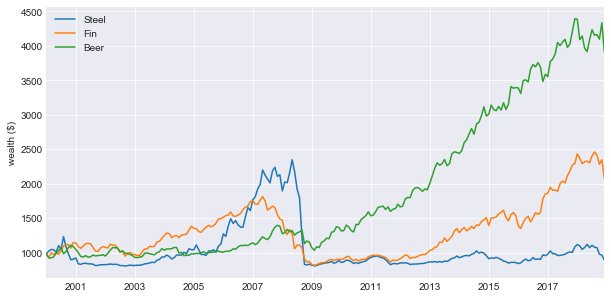

In [97]:
ax = account_history.plot(figsize=(10,5), grid=True)
ax.set_ylabel("wealth ($)")
plt.show()

and let us compare the CPPI strategies with the risky wealths in case of a $100\%$ investment in the risky assets:

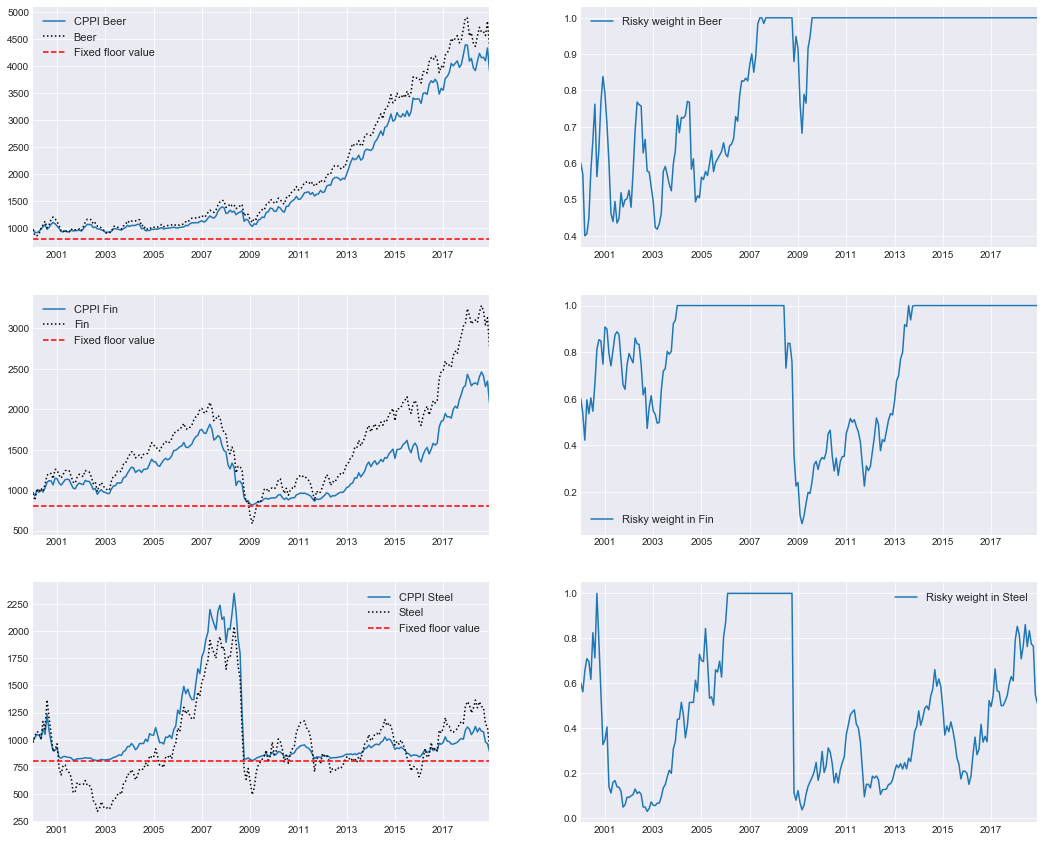

In [34]:
fig, ax = plt.subplots(3,2,figsize=(18,15))
ax = ax.flatten()

# Beer
account_history["Beer"].plot(ax=ax[0], grid=True, label="CPPI Beer")
risky_wealth["Beer"].plot(ax=ax[0], grid=True, label="Beer", style="k:")
ax[0].axhline(y=floor_value, color="r", linestyle="--", label="Fixed floor value")
ax[0].legend(fontsize=11)

# Weights Beer
risky_w_history["Beer"].plot(ax=ax[1], grid=True, label="Risky weight in Beer")
ax[1].legend(fontsize=11)

# Fin
account_history["Fin"].plot(ax=ax[2], grid=True, label="CPPI Fin")
risky_wealth["Fin"].plot(ax=ax[2], grid=True, label="Fin", style="k:")
ax[2].axhline(y=floor_value, color="r", linestyle="--", label="Fixed floor value")
ax[2].legend(fontsize=11)

# Weights Fin
risky_w_history["Fin"].plot(ax=ax[3], grid=True, label="Risky weight in Fin")
ax[3].legend(fontsize=11)

# Steel
account_history["Steel"].plot(ax=ax[4], grid=True, label="CPPI Steel")
risky_wealth["Steel"].plot(ax=ax[4], grid=True, label="Steel", style="k:")
ax[4].axhline(y=floor_value, color="r", linestyle="--", label="Fixed floor value")
ax[4].legend(fontsize=11)

# Weights Steel
risky_w_history["Steel"].plot(ax=ax[5], grid=True, label="Risky weight in Steel")
ax[5].legend(fontsize=11)

plt.show()

As expected, in case of growth periods, the blue line, which is the growth due to the CPPI strategy is normally below the dotted line, which is the growth due to a $100\%$ investment in the risky asset. 

In the case of Beer, we see that from about 2009 the weights of the portfolio becomes $1$ to the risky asset and $0$ to the safe asset, i.e., from 2009 we only invested purely in Beer.

For what concern Finance, the situation is different and we can see the advantage of the CPPI strategy. During the Lehman Brothers crisis, 
a pure investment in Fin would have resulted in a loss that breaks the floor value (note the dotted line going below the red line). On the other hand, we see that the blue line stays above the floor and only from about 2013 the risky weight in Fin becomes $1$ again.

Let us compare statistics of the pure risky asset investment and of the CPPI strategy:

In [35]:
erk.summary_stats( risky_rets )

,Ann. return,Ann. vol,Sharpe ratio,Skewness,Kurtosis,Historic CVar,C-F Var,Max Drawdown
Steel,-0.002790,0.312368,-0.102567,-0.326334,4.144381,0.208117,0.150139,-0.758017
Fin,0.055166,0.192909,0.126718,-0.533218,4.995534,0.132175,0.091224,-0.718465
Beer,0.080598,0.138925,0.354314,-0.493545,4.173881,0.091442,0.063015,-0.271368


In [36]:
erk.summary_stats( cppi_rets )

,Ann. return,Ann. vol,Sharpe ratio,Skewness,Kurtosis,Historic CVar,C-F Var,Max Drawdown
Steel,-0.005167,0.174180,-0.196750,-1.995143,17.110190,0.130153,0.091995,-0.655198
Fin,0.040894,0.131678,0.080352,-0.946504,6.051414,0.091621,0.065535,-0.549673
Beer,0.075544,0.115462,0.383772,-0.669250,4.760879,0.074908,0.052923,-0.259582


If we look at drawdowns, we see that the pure investment in the risky assets would incur in higher losses (drawdowns). 
On the other hand, higher returns are also expected. In fact Beer, for instance, has a annualized return of about $8\%$ versus $7\%$ of the CPPI investment strategy.

### Implementing the drawdown constraint

So far, in our CPPI strategy we had a fixed floor value. However, this is not exactly what an investor would like to do. 
We would like to **dinamically update the floor value** as long as the wealth of our portfolio increase such that the changes 
according to the **previous peak** of the wealth growth.

We have implemented the CPPI in a method in our kit, so we now run the second version of the CPPI using the kit's method. 
In case the drawdown is present, the method imposes the multiplier $m=1/\text{drawdown}$. 

For example, let us consider $\text{drawdown}=0.2$ (i.e., $20\%$):

In [37]:
res = erk.cppi(risky_rets, start_value=1000, floor=0.8, drawdown=0.2, risk_free_rate=0.03, periods_per_year=12)

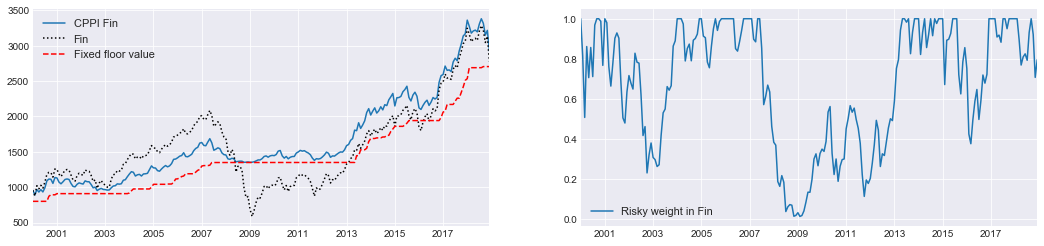

In [38]:
sector = "Fin"

fig, ax = plt.subplots(1,2,figsize=(18,4))
ax = ax.flatten()

res["CPPI wealth"][sector].plot(ax=ax[0], grid=True, label="CPPI "+sector)
res["Risky wealth"][sector].plot(ax=ax[0], grid=True, label=sector, style="k:")
res["Floor value"][sector].plot(ax=ax[0], grid=True, color="r", linestyle="--", label="Fixed floor value")
ax[0].legend(fontsize=11)

# Weights Beer
res["Risky allocation"][sector].plot(ax=ax[1], grid=True, label="Risky weight in "+sector)
ax[1].legend(fontsize=11)

plt.show()

Compare the statistics of the sector pure risky returns and of the CPPI returns:

In [39]:
erk.summary_stats( risky_rets[sector] )

,Ann. return,Ann. vol,Sharpe ratio,Skewness,Kurtosis,Historic CVar,C-F Var,Max drawdown
0,0.055166,0.192909,0.126718,-0.533218,4.995534,0.132175,0.091224,-0.718465


In [40]:
erk.summary_stats( res["CPPI returns"][sector] )

,Ann. return,Ann. vol,Sharpe ratio,Skewness,Kurtosis,Historic CVar,C-F Var,Max drawdown
0,0.060906,0.103468,0.290592,-0.162753,3.852636,0.061659,0.04449,-0.198261


As expected, the maximum drawdown taken from the CPPI strategy has been about $19.8\%$, and overall it had an annual return of $6\%$. 
Observe the behaviour of the CPPI strategy when changing the maximum drawdown accepted:

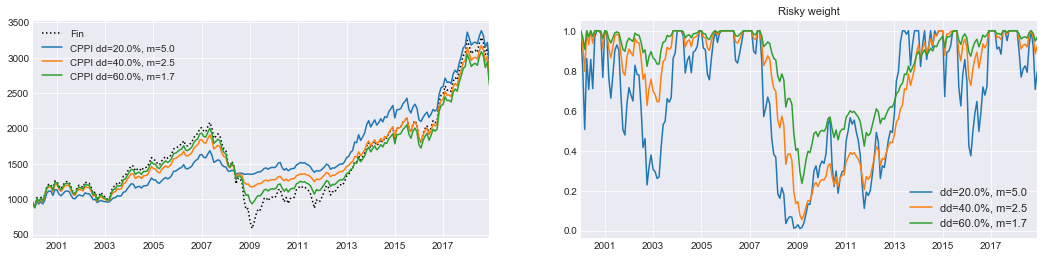

In [42]:
sector = "Fin"
drawdowns = [0.2, 0.4, 0.6]
    
fig, ax = plt.subplots(1,2,figsize=(18,4))
ax = ax.flatten()

res["Risky wealth"][sector].plot(ax=ax[0], grid=True, style="k:", label=sector)
ax[0].legend()

summ = pd.DataFrame()
for drawdown in drawdowns:
    res = erk.cppi(risky_rets, start_value=1000, floor=0.8, drawdown=drawdown, risk_free_rate=0.03, periods_per_year=12)    
    res["CPPI wealth"][sector].plot(ax=ax[0], grid=True, label="CPPI dd={}%, m={}".format(drawdown*100,round(res["m"],1)) )
    res["Risky allocation"][sector].plot(ax=ax[1], grid=True, label="dd={}%, m={}".format(drawdown*100,round(res["m"],1)) )
    
    summ = pd.concat([summ, erk.summary_stats(res["CPPI returns"][sector])], axis=0)
        
ax[0].legend() 
ax[1].legend(fontsize=11)
ax[1].set_title("Risky weight", fontsize=11)
plt.show()

In [45]:
summ.index = [["DD20%","DD40%","DD60%"]]
summ

,Ann. return,Ann. vol,Sharpe ratio,Skewness,Kurtosis,Historic CVar,C-F Var,Max drawdown
DD20%,0.060906,0.103468,0.290592,-0.162753,3.852636,0.061659,0.044490,-0.198261
DD40%,0.056471,0.122929,0.209429,-0.100930,4.300426,0.076818,0.053106,-0.386458
DD60%,0.054642,0.142893,0.167664,-0.300973,4.190644,0.091483,0.064867,-0.533947


## Random walk generation - Geometric Brownian Motion 

A **Wiener process** $W_{t}$ is a real valued continuous-time **stochastic process** characterised by the following properties:
 1. $W_{0}=0$;
 2. $W$ has independent increments, i.e., for every $t>0$ the future increments $W_{t+u}-W_{t}$ (for $u\geq 0$) 
 are independent of the past values $W_{s}$, for all $s< t$; 
 3. $W$ has Gaussian increments, i.e., $W_{t+u}-W_{t}$ is normally distributed with mean $0$ and variance $u$, $W_{t+u}-W_t \sim{\mathcal {N}}(0,u)$; 
 4. $W$ has continuous paths, i.e., $W_{t}$ is continuous in $t$. 

Due to these features, we have that $\mathbb{E}[W_t]=0$, $\text{Var}(W_t) = t$ for a fixed time $t$ and the unconditional 
probability density function is then: 
$$
f_{W_{t}}(x) = \frac{1}{ \sqrt{2\pi t} } e^{\frac{-x^2}{2t}}. 
$$

### Geometric Brownian Motion 

A **stochastic process** $S_t$ is said to follow a **geometric Brownian Motion** (GBM) 
if it satisfies the following **stochastic differential equation** (SDE):
$$
dS_{t} = \mu S_{t}\,dt + \sigma S_t \, dW_{t} 
$$
where $W_{t}$ is a **Brownian motion** (i.e. a Wiener process), 
$\mu$ is called the (percentage) **drift**, and 
$\sigma$ is called the (percentage) **volatility**. Both the drift and the volatility are constants. 
While the drift is used to model a **trend** of the stochastic process, the volatility models unpredictable events 
occurring during this motion (basically, how much the process oscillates around its drift).

#### Returns

In the equation, $dS_t = S_{t+dt} - S_t$ (and so $dW_t = W_{t+dt} - W_t$) for $dt>0$. 
Note that if we divide by $S_t$:
$$
\frac{S_{t+dt} - S_t}{S_t} = \mu dt + \sigma (W_{t+dt} - W_t). 
$$
The quantity on the left-hand side is nothing but that the **percentage return**. 

Also, since $W$ has Gaussian increments $W_{t+dt} - W_t$ 
with zero mean variance $dt$, we can then substitute the increment with a random variable defined as $\sqrt{dt}\xi_t$, 
where $\xi_t \sim \mathcal{N}(0,1)$ for all $t$. 
In fact, $\mathbb{E}[\sqrt{dt}\xi_t] = 0$ and $\text{Var}(\sqrt{dt}\xi_t) = dt\text{Var}(\xi_t)=dt$. 
Therefore, we can rewrite:
$$
\frac{S_{t+dt} - S_t}{S_t} = \mu dt + \sigma \sqrt{dt}\xi_t, 
\quad\xi_t\sim\mathcal{N}(0,1), \; \forall\; t,
$$
and this gives us **a formula to actually generate (percentage) returns** from a geometric brownian motion.
Notice that 
$$
\begin{align}
\mathbb{E}\left[\mu dt + \sigma \sqrt{dt}\xi_t\right] &= \mu dt + \sigma \sqrt{dt} \mathbb{E}[\xi_t] = \mu dt, \\
\text{Var}\left[\mu dt + \sigma \sqrt{dt}\xi_t\right] &= \sigma^2 dt \text{Var}(\xi_t) = \sigma^2 dt,
\end{align}
$$
that is the returns generated in this way have mean $\mu dt$ and volatility $\sigma \sqrt{dt}$.


#### Prices and log-returns

Note that if we divide by $dt$ the stochastic differential equation we have:
$$
\frac{S_{t+dt} - S_t}{dt} = S_t \left( \mu + \sigma \frac{dW_t}{dt} \right), 
$$
which represents the evolution of the process over time. For example, the process $S_t$ can be a **stock price**. 
A solution to the equation can be provided by the following argument.

First of all, we have:
$$
\log(1 + x) \approx x - \frac{x^2}{2},
$$
when $x$ is sufficiently small.
Therefore: 
$$
\begin{equation}
\begin{split}
\log\left( \frac{S_{t+dt}}{S_t} \right) = \log\left(1 + \frac{S_{t+dt} - S_t}{S_t}\right) 
&\approx \frac{S_{t+dt} - S_t}{S_t} - \frac{1}{2}\left( \frac{S_{t+dt} - S_t}{S_t} \right)^2 \\
&\approx \mu dt + \sigma \sqrt{dt}\xi_t - \frac{1}{2} \left( \mu dt + \sigma \sqrt{dt}\xi_t \right)^2 \\
&\approx \mu dt + \sigma \sqrt{dt}\xi_t - \frac{1}{2} \left( \mu^2 \underbrace{dt^2}_{\approx 0} + \sigma^2 dt \underbrace{\xi_t^2}_{\approx \mathbb{E}[\xi_t^2]=1}   + 2\mu \underbrace{dt \sqrt{dt}}_{\approx 0} \sigma \xi_t \right) \\
&\approx \mu dt + \sigma \sqrt{dt}\xi_t - \frac{1}{2} \sigma^2 dt = \left(\mu - \frac{\sigma^2}{2}\right)dt + \sigma\sqrt{dt}\xi_t.
\end{split}
\end{equation}
$$
The quantity on the left-hand side of the equation above is called **log-return** and it follows a dynamic similar to that of the classic percentage return (see above). The difference is that the equation for the og-return a **scaled drift** ($\mu-\sigma^2/2$).

Taking the exponential on both sides:
$$
S_{t+dt} \approx S_t \exp\left( \left(\mu - \frac{\sigma^2}{2}\right)dt + \sigma\sqrt{dt}\xi_t  \right).
$$
Right. To obtain the solution, just note that for every unit $t = ndt$, for a given $n\in\mathbb{N}$, then
$$
\begin{align}
S_t = S_{0+ndt} \approx S_0 \exp\left( \left(\mu - \frac{\sigma^2}{2}\right) (ndt) + \sigma\sqrt{ndt}\xi_t \right)
= S_0 \exp\left( \left(\mu - \frac{\sigma^2}{2}\right)t + \sigma\sqrt{t}\xi_t  \right) 
= S_0 \exp\left( \left(\mu - \frac{\sigma^2}{2}\right)t + \sigma W_t  \right) 
\end{align}
$$
This is the equation for the evolution, for example, of a stock price starting from an initial price of $S_0$. 

In our kit we have two functions whichc generate stock prices in the two ways we have seen above, one by **compounding the percentage 
returns which follow a GBM**, and one by **solving the GBM equation satisfied by the log-returns**:

In [11]:
prices_1, rets_1 = erk.simulate_gbm_from_returns(n_years=10, n_scenarios=10, mu=0.07, sigma=0.15, periods_per_year=12, start=100.0)
prices_2, rets_2 = erk.simulate_gbm_from_prices(n_years=10, n_scenarios=10, mu=0.07, sigma=0.15, periods_per_year=12, start=100.0)

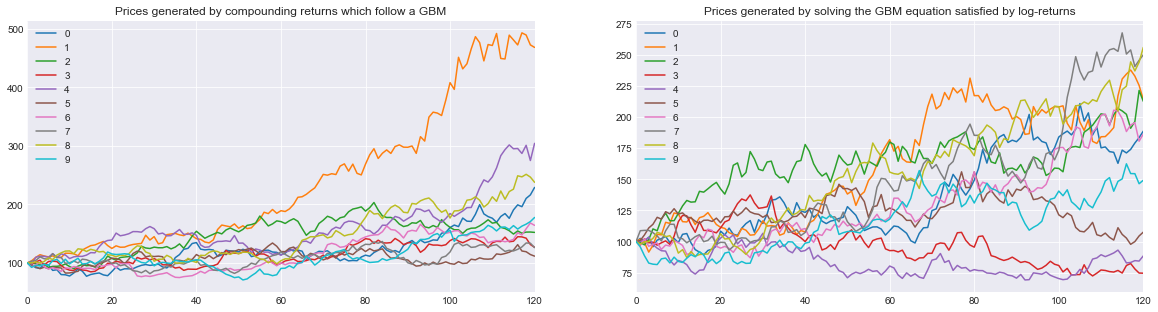

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
prices_1.plot(ax=ax[0], grid=True, title="Prices generated by compounding returns which follow a GBM")
prices_2.plot(ax=ax[1], grid=True, title="Prices generated by solving the GBM equation satisfied by log-returns")
plt.show()

Sometimes the **drift** $\mu$ in the geometric Brownian motion is decomposed so that to emphasize the risk-free rate, the volatility, and the sharpe ratio. In fact, recall that the **sharpe ratio** of a stock index was given by
$$
\text{SR} := \lambda = \frac{R_s - R_f}{\sigma} 
\quad\Longrightarrow\quad 
R_s = R_f + \sigma \lambda, 
$$
with $\sigma$ being the volatility of the stock index, $R_f$ being the risk-free rate, and $R_s$ being the annualized return from the stock index. 

From this, we see that since **$\mu$ denotes the expected return of the stock index that we are modelling**, we simply want to emphasize that such **expected return on the risky stock index is given by a risk-free rate $R_f$ plus a risky premium** given by the unit of risk, i.e., the volatility $\sigma$, times the reward per unit per risk, i.e., the sharpe ratio $\lambda$. 

Therefore, we may find the geometric Brownian motion of (percentage) returns with $\mu$ substitued by:
$$
\frac{dS_{t}}{S_t} = (R_f + \sigma \lambda) dt + \sigma dW_{t}. 
$$

#### Interactive random walk simulation

Using **ipywidgets** we can obtain interactive plots. Let us make interactive plots of random walk simulation:

In [48]:
import ipywidgets as widgets

The function used is called **show_gbm** and basically it simply generate some random walks by calling the **simulate_gbm_from_returns** 
method and plot the random prices. The widget makes the plot interactive:

In [49]:
gbm_controls = widgets.interact(erk.show_gbm, 
                                n_years = (1, 10, 1),
                                n_scenarios = (1, 100, 1),
                                mu = (-0.30, 0.30, 0.01),
                                sigma = (0.0, 0.50, 0.01),
                                periods_per_year = [12, 52, 252],
                                start = [100]
                               )

interactive(children=(IntSlider(value=10, description='n_years', max=10, min=1), IntSlider(value=10, descripti…

The GBM is used to model stock prices in the **Black–Scholes model** and is the most widely used model of stock price behavior.

Some of the arguments for using GBM to model stock prices are the following:

 - The expected returns of GBM are independent of the value of the process (stock price), which agrees with what we would expect in reality;
 - The GBM process only assumes positive values, as real stock prices;
 - The GBM process shows the same kind of *roughness* in its paths as we see in real stock prices;
 - Calculations with GBM processes are relatively easy.
 
However, GBM is not a completely realistic model, in fact: 
 - In real stock prices, volatility changes over time (possibly stochastically), but in GBM processes, volatility is assumed constant;
 - In real life, stock prices often show jumps caused by, for example, news, whereas in GBM processes the path is continuous.

#### Interactive CPPI simulation - Monte Carlo

Here, we called the method **show_cppi** in out kit 
which simulates a CPPI investment strategy starting by returns generated by geometric Brownian Motion. 
We consider only the case of a fixed floor, i.e., the case with no drawdown contraint.

Using the widget interact we make the plot interactive:

In [50]:
cppi_controls = widgets.interact(erk.show_cppi, 
                                 n_years = (1, 10, 1),
                                 n_scenarios = (1, 300, 1),
                                 m = (1, 6, 0.5),
                                 floor = (0.0, 1.0, 0.05),
                                 mu = (-0.2, 0.4, 0.01),
                                 sigma = (0.0, 0.5, 0.01),
                                 risk_free_rate = (0.01, 0.05, 0.01),
                                 periods_per_year = [12, 52, 252],
                                 start = [100],
                                 ymax = widgets.IntSlider(min=0, max=100, value=100, step=1, description="Zoom Y axis")
                               )

interactive(children=(IntSlider(value=10, description='n_years', max=10, min=1), IntSlider(value=50, descripti…